# Report
## Problem description
...

## Structure
The solution is divided into the following parts. Only XGBOOST (part 4) is used in the final submission.
1. Initialisation
2. Neural Networks
3. TabNet
4. XGBOOST



## 1. Initialisation

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from pytorch_tabnet.tab_model import TabNetClassifier

import xgboost as xgb

In [2]:
## Set up logging, device, seed and scaler
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

seed = 69
torch.manual_seed(seed)
scaler = RobustScaler()

2024-10-11 23:29:25,502 - INFO - Using device: cpu


In [3]:
## Load and Preprocess Data

# Transform data but not binary columns
def transform_data(df):
    binary_columns = codebook[codebook['Type'] == 'binary']['Variable Name'].values
    non_binary_columns = [col for col in df.columns if col not in binary_columns]
    
    df[non_binary_columns] = scaler.fit_transform(df[non_binary_columns])

    return df

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
codebook = pd.read_csv('codebook.csv')

logger.info("Data loaded successfully")
logger.info("Original Training data shape: %s", str(train_data.shape))
logger.info("Original Prediction data shape: %s", str(test_data.shape))

X = train_data.drop(columns=['target'])
colnames_X = X.columns
y = train_data['target']

# Split data into training, validation, and test sets for NN
X_train, X_temp, y_train, Y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=0.33, random_state=seed)

# Split data for XGBoost
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train_XGB_preTransform = X_train_XGB.copy()
X_train_XGB = transform_data(X_train_XGB)
X_test_XGB = transform_data(X_test_XGB)

X_train_XGB = X_train_XGB.values.astype(np.float32)
X_test_XGB = X_test_XGB.values.astype(np.float32)
y_train_XGB = y_train_XGB.values.astype(np.int64)
y_test_XGB = y_test_XGB.values.astype(np.int64)

X_full_XGB = transform_data(X)
X_full_XGB = X_full_XGB.values.astype(np.float32)
y_full_XGB = y.values.astype(np.int64)

# Prepare test data
X_external_test = test_data
X_external_test = transform_data(X_external_test)
X_external_test = X_external_test.values.astype(np.float32)

logger.info("Shape of Train data: %s", str(X_train_XGB.shape))
# logger.info("Shape of Validation data: %s", str(X_val.shape))
logger.info("Shape of Test data: %s", str(X_test_XGB.shape))

logger.debug("Example of standardized data:")
logger.debug(X_train.head())


# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

# Check class imbalance
y_train_series = pd.Series(y_train_XGB)
logging.info(f"Imbalance y:\n{y_train_series.value_counts(normalize=True)}")

2024-10-11 23:29:25,838 - INFO - Data loaded successfully
2024-10-11 23:29:25,839 - INFO - Original Training data shape: (20132, 160)
2024-10-11 23:29:25,840 - INFO - Original Prediction data shape: (5034, 159)
2024-10-11 23:29:26,248 - INFO - Shape of Train data: (18118, 159)
2024-10-11 23:29:26,248 - INFO - Shape of Test data: (2014, 159)
2024-10-11 23:29:26,284 - INFO - Imbalance y:
0    0.788498
1    0.211502
Name: proportion, dtype: float64


2024-09-25 13:25:19,997 - INFO - Number of continuous variables: 42


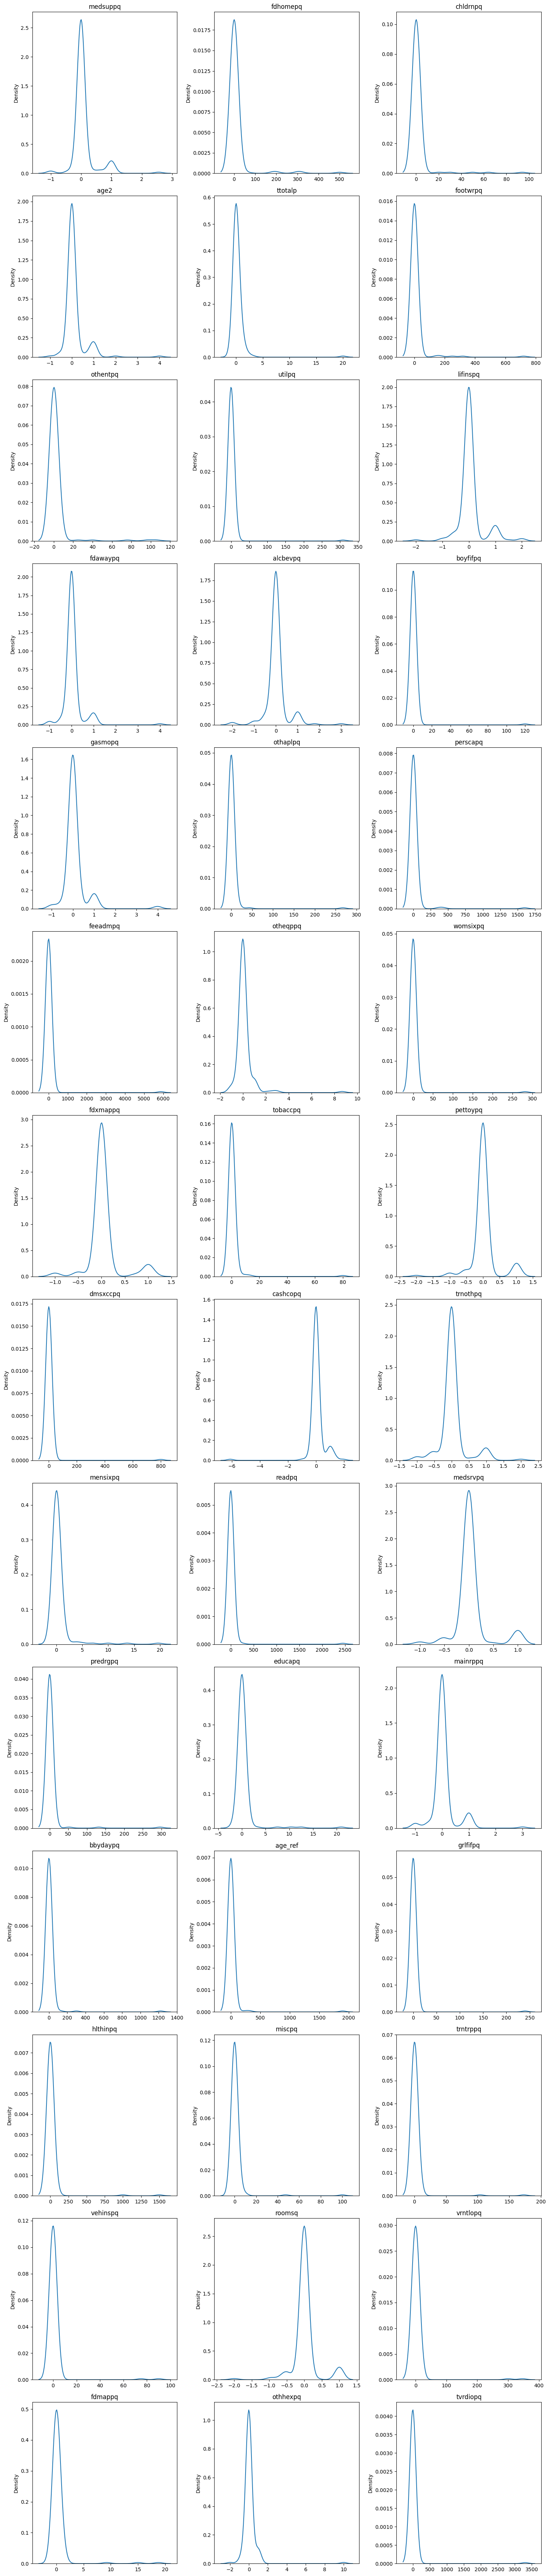

In [132]:
## Plot continuous variables
continuous_columns = codebook[codebook['Type'] == 'continuous']['Variable Name'].values
logging.info(f"Number of continuous variables: {len(continuous_columns)}")

n_vars = len(continuous_columns)
n_subplots = 3 

# Create subplots
rows = (n_vars // n_subplots) + (n_vars % n_subplots > 0)
fig, ax = plt.subplots(rows, n_subplots, figsize=(15, 5 * rows))
ax = ax.flatten()

# Plot each variable
for i, col in enumerate(continuous_columns):
    if i < len(ax):
        pos = colnames_X.get_loc(col)
        logging.debug(f"Column: {col}, Position: {pos}")
        sns.kdeplot(X_train_XGB[pos], ax=ax[i])
        ax[i].set_title(col)

# Hide any unused subplots
for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

## 2. Neural Networks

In [15]:
## Define the Neural Networks

class TestNN(nn.Module):
    def __init__(self, input_dim):
        super(TestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
class NN(nn.Module):
    def __init__(self, input_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# LargerNN
# "what do you mean it overfits lol"
class LargeNN(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(LargeNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.sigmoid(x)

        return x


In [61]:
# Define hyperparameters
batch_size = 32
nEpochs = 300
learning_rate = 0.001

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
# model = FeedforwardNN(input_dim).to(device)
model = NN(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [62]:
## Define the training and evaluation functions

# Train
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, print_every=1):
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)

            logger.debug(f"Model output shape: {outputs.shape}")
            logger.debug(f"Label shape: {labels.shape}")

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
        
        # Train acc
        train_accuracy = correct_preds / total_preds
        train_accuracies.append(train_accuracy)
        
        # Validation acc
        val_preds, val_labels = evaluate_model(model, val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)
        
        epoch_loss = running_loss / len(train_loader.dataset)

        if (epoch + 1) % print_every == 0:
            logger.info(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Time elapsed: {time.time() - start_time:.2f}s')

    logger.info(f'Training complete. Total time elapsed: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')
    
    return train_accuracies, val_accuracies

# Eval
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds).flatten(), np.array(all_labels).flatten()


In [ ]:
## Train model

# Function to plot training and validation accuracies
def plot_accuracies(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    
    plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
    
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


# Train
train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=nEpochs)

# Plot training and validation accuracy
plot_accuracies(train_accuracies, val_accuracies)

In [ ]:
## Evaluate the model

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Prepare test data
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate on validation set
val_preds, val_labels = evaluate_model(model, val_loader)
logger.info(f"Validation Accuracy: {accuracy_score(val_labels, val_preds):.4f}")

# Evaluate on test set
test_preds, test_labels = evaluate_model(model, test_loader)
logger.info(f"Test Accuracy: {accuracy_score(test_labels, test_preds):.4f}")

# Classification report
logger.info(f"Classification Report:\n{classification_report(test_labels, test_preds)}")

# Confusion matrix
plot_confusion_matrix(test_labels, test_preds)

## 3. TabNet

In [ ]:
# Define model
TabNetClassifier
clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=10,
    gamma=1.5,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-4),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="sparsemax"
)

# Train the model
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=100, patience=15,
    batch_size=256, virtual_batch_size=128
)

## 4. XGBOOST

In [12]:
## Train model
start_time = time.time()

model = xgb.XGBClassifier(n_estimators=5000, eval_metric='logloss', objective='binary:logistic', random_state=seed, device=device)

# model = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.1, max_delta_step = 2, reg_alpha=0.75, reg_lambda=0.5, device=device, eval_metric='logloss', random_state=seed, objective='binary:logistic')

# model.fit(X_train_XGB, y_train_XGB)
# model.score(X_test_XGB, y_test_XGB)

# Hyperparameters
HP_learning_rate = [0.05, 0.1, 0.2]
HP_max_delta_step = [1, 2, 3]
HP_reg_alpha = [0.25, 0.5, 0.75]
HP_reg_lambda = [0.25, 0.5, 0.75]
K = 10

# Length of overall grid
grid_length = len(HP_learning_rate) * len(HP_max_delta_step) * len(HP_reg_alpha) * len(HP_reg_lambda)
logger.info(f"Total number of hyperparameter combinations: {grid_length}")
logger.info(f"Expected time to complete: {grid_length * 3 / 60} hrs.")


# GridSearchCV
param_grid = {
    'learning_rate': HP_learning_rate,
    'max_delta_step': HP_max_delta_step,
    'reg_alpha': HP_reg_alpha,
    'reg_lambda': HP_reg_lambda,
}

grid_search = GridSearchCV(model, param_grid, cv=K, scoring='accuracy', n_jobs=-1, verbose=2, refit=True)
grid_search.fit(X_train_XGB, y_train_XGB)
logger.info(f"Grid search done. Total time elapsed: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")

# Save to file  
joblib.dump(grid_search, 'xgb_grid_search.pkl')
paramDF = pd.DataFrame(grid_search.cv_results_)
paramDF.to_csv('xgb_grid_search_param_results.csv')
logger.info("Grid search results saved to file")

2024-10-04 13:55:01,423 - INFO - Total number of hyperparameter combinations: 81
2024-10-04 13:55:01,424 - INFO - Expected time to complete: 4.05 hrs.


In [8]:
## Evaluate model

# Load the model
model = joblib.load('xgb_grid_search_eerste sessie.pkl')

# Evaluate the model on a validation set
y_pred = model.predict(X_test_XGB)
accuracy = accuracy_score(y_test_XGB, y_pred)
logger.info(f"Final Test Accuracy: {accuracy:.4f}")

2024-10-04 13:42:18,459 - INFO - Final Test Accuracy: 0.8416


In [4]:
## Train model on entire train.csv dataset for submission with best hyperparameters from grid search

# Params
F_learning_rate = 0.1
F_delta_step = 1
F_alpha = 0.75
F_lambda = 0.25
n_estimators = 3000

# Train
F_model = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=F_learning_rate, max_delta_step=F_delta_step, reg_alpha=F_alpha, reg_lambda=F_lambda, device=device, eval_metric='logloss', random_state=seed, objective='binary:logistic')
F_model.fit(X_full_XGB, y_full_XGB)

# Save model
joblib.dump(F_model, 'xgb_final_model.pkl')
logger.info("Final model saved to file")

# (Optional) Load model
# F_model = joblib.load('xgb_final_model.pkl')

# Predict on test.csv
y_pred_external = F_model.predict(X_external_test)

# Format predictions and save to file
predictions = ''.join([str(int(x)) for x in y_pred_external])
with open('predictions.txt', 'w') as f:
    f.write(predictions)
logger.info("Predictions saved to file")


2024-10-11 23:29:39,520 - INFO - Final model saved to file
2024-10-11 23:29:39,628 - INFO - Predictions saved to file
